## Imports

In [5]:
from chord_geometry_int import ChordGeometryInterferometry
from magnetic_equilibrium import MagneticEquilibrium, MagneticEquilibriumSinglePoint
from interferometry import Interferometry, InterferometrySinglePoint
from density_profile import DensityProfile, DensityProfileSinglePoint
from forward_1d_triangle_int import compute_response_matrix, plot_geometry_with_mag_equi
import matplotlib.pyplot as plt


import numpy as np
# from tqdm import tqdm
import scipy
from scipy.optimize import minimize, basinhopping
import optuna
import os
from pathlib import Path
import skvideo.io
import IPython

from matplotlib.backends.backend_agg import FigureCanvasAgg
import matplotlib.pyplot as plt
import numpy as np
def fig2np(fig):
    canvas = FigureCanvasAgg(fig)
    canvas.draw()
    return np.array(canvas.buffer_rgba())

%matplotlib inline

/home/daniel/anaconda3/envs/mthesis/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load data (of a single time slice)

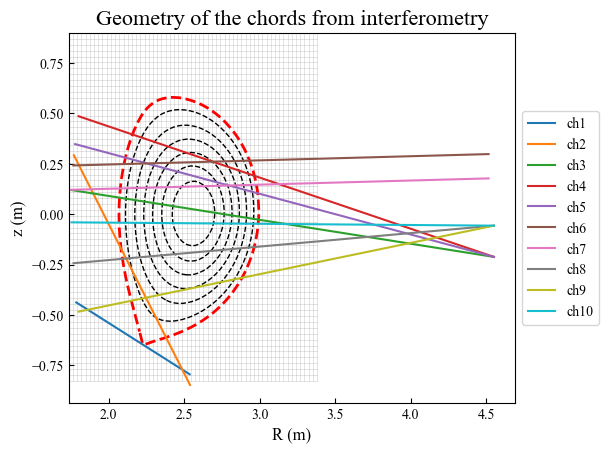

In [6]:
shot = 53259 # Shot number
t = 5.21    # Time (relative to the start of plasma)

# Geometry of the chords from interferometer (lines of sight)
geo = ChordGeometryInterferometry(f'data/WEST/{shot}/los_interferometer_{shot}.mat')

# Magnetic equilibrium calculated by equilibrium code NICE
equi_all = MagneticEquilibrium()
equi_all.load_from_imas(f'data/WEST/{shot}/imas_equilibrium_{shot}.mat', shot=shot)
equi = equi_all.get_single_point(t)

# Line integrated electron density measured by interferometer
interf_all = Interferometry()
interf_all.load_from_imas(f'data/WEST/{shot}/imas_interferometer_{shot}.mat', shot=shot)
interf = interf_all.get_single_point(t)

# Density profile calculated by equilibrium code NICE, to be used to generate synthetic data
dens_prof_all = DensityProfile()
dens_prof_all.load_from_imas(f'data/WEST/{shot}/imas_core_profiles_{shot}.mat', shot=shot)
dens_prof = dens_prof_all.get_single_point(t)

plot_geometry_with_mag_equi(geo, equi)

## Plotting The NICE profile and vrious Data Options

The responce martix is applied to the NICE profile to generate ground truth data for a simulation where NICE is the exact profile in the TOKAMAK.

Some noise is added to the ground truth data to generate synthetic data.

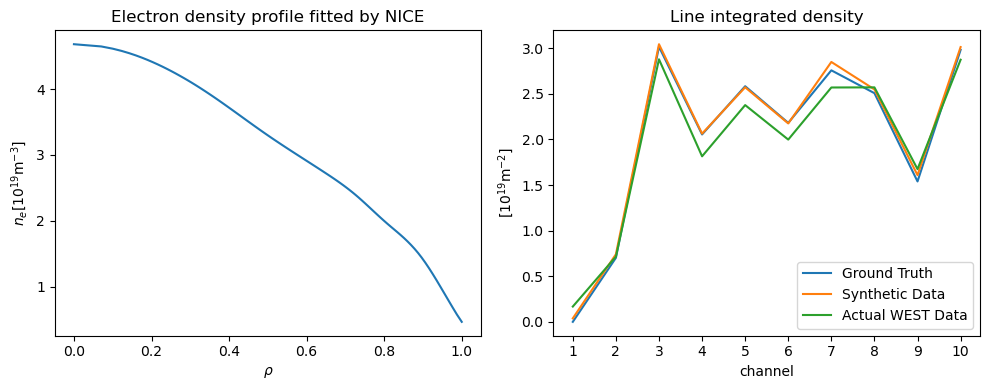

In [7]:
EXP_ER = 0.03 #background noise order of magnitude
M = len(interf.channels.compressed()) #number of channels 
def data_gen(prof_1d, R):
    lid_true = R @ prof_1d
    lid_data = lid_true + np.random.normal(loc=0, scale=EXP_ER, size=len(lid_true))
    return lid_true, lid_data
                                          
# The response matrix used for calculating line integrals
R = compute_response_matrix(geo, equi, dens_prof.rho_tor_norm_1d)

lid_true, lid_data = data_gen(dens_prof.dens_1d,R)                                           

fig = plt.figure(figsize=(10, 4))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
nice = dens_prof.dens_1d
ax1.plot(dens_prof.rho_tor_norm_1d, dens_prof.dens_1d)
ax1.set_xlabel(r'$\rho$')
ax1.set_ylabel(r'$n_e[\mathrm{10^{19} m^{-3}}]$')
ax1.set_title('Electron density profile fitted by NICE')

ax2.plot(interf.channels.compressed(), lid_true, label='Ground Truth')
ax2.plot(interf.channels.compressed(), lid_data, label='Synthetic Data')
ax2.plot(interf.channels.compressed(), interf.lid.compressed(), label='Actual WEST Data')

ax2.set_xticks(interf.channels.data)
ax2.set_xlabel('channel')
ax2.set_ylabel(r'$[\mathrm{10^{19} m^{-2}}]$')
ax2.set_title('Line integrated density')
ax2.legend()
plt.tight_layout()

# Setting Data

In [8]:
# Ground Trueth. Assuming a profile is true what is the exact LID for each channel?
# lid_d = lid_true
# Synthetic data, gaussian noise added to ground truth
lid_d = lid_data
# Real Data for each channel from west
# lid_d = interf.lid.compressed()


# Static OR non-Static Kernel

array([[5.62000003, 5.61651351, 5.61296674, ..., 1.45067992, 1.4326895 ,
        1.41525376],
       [5.61651351, 5.62000003, 5.61938325, ..., 1.49945112, 1.48144193,
        1.46404716],
       [5.61296674, 5.61938325, 5.62000003, ..., 1.51932456, 1.50132637,
        1.48396842],
       ...,
       [1.45067992, 1.49945112, 1.51932456, ..., 5.62000003, 5.5889408 ,
        5.48336817],
       [1.4326895 , 1.48144193, 1.50132637, ..., 5.5889408 , 5.62000003,
        5.58180246],
       [1.41525376, 1.46404716, 1.48396842, ..., 5.48336817, 5.58180246,
        5.62000003]])

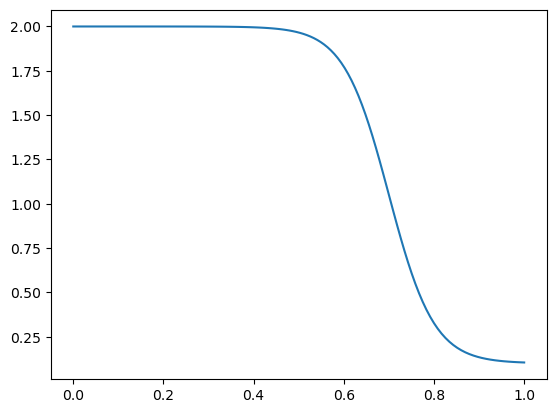

In [39]:
##Prior
rho_1d = dens_prof.rho_tor_norm_1d
N = len(rho_1d)
def parabola(rho):
    return 4.9*(1-rho**2)
mu_prior = np.zeros(N)#parabola(rho_1d)#np.zeros(N)#dens_prof.dens_1d#
#exponential square kernel

STATIC = 3
# 1 means completly static
# 2 means static amp but non static length-scale
# 3 means static amp but non static length-scale with a hyperbolic tangent functional form 
# 4 means static amp but non static length-scale with a exonential decay functional form 
# 5 means non static length scale and amp

if STATIC==1:
    def Kernel(rho_1d,params):
        RHOA, RHOB = np.meshgrid(rho_1d,rho_1d)
        #amplitude determins how far the model can go from the mean
        amp = params[0]
        #length scale determines smoothness, how correlated the function should be at a distance
        l = params[1]
        return amp**2 * np.ones((len(rho_1d),len(rho_1d)))#* np.exp(-((RHOA-RHOB)*(RHOA-RHOB))/(2*l**2))
    initial_params = [4,0.19]
    # initial_params = [5.62,1.37]
    # initial_params = [5.62,10]
elif STATIC==2:
    def Kernel(rho_1d,params):
        RHOA, RHOB = np.meshgrid(rho_1d,rho_1d)
        #amplitude determins how far the model can go from the mean
        amp = params[0]
        #length scale determines smoothness, how correlated the function should be at a distance
        l = np.array(params[1:])
        LA, LB = np.meshgrid(l,l)
        mag = (RHOA - RHOB) * (RHOA - RHOB)
        scale1 = 2 * LA * LB
        scale2 = (LA * LA) + (LB * LB)
        frac = (scale1/scale2) + np.diag(np.repeat(1e-8,len(rho_1d)))    
        return amp * np.sqrt(frac) * np.exp(-(mag/scale2))
    #large l for first three 
    #initial_params = ([5.62]+list(np.repeat(10,3))+list(np.repeat(1.37,len(rho_1d)-3)))
    initial_params = ([5.62]+list(np.repeat(1.37,len(rho_1d))))
    #exponential decay of correlation length. Creates a flat area at 0.
    # l_initial = list(10*np.exp(-2*rho_1d))
    # initial_params = ([5.62]+l_initial)
    # plt.plot(rho_1d,l)

elif STATIC==3:
    def Kernel(rho_1d,params):
        RHOA, RHOB = np.meshgrid(rho_1d,rho_1d)
        #amplitude determins how far the model can go from the mean
        amp = params[0]
        #length scale determines smoothness, how correlated the function should be at a distance
        core_l, edge_l, transition_center, transition_width = params[1:]
        def HyperTan_l(rho):
            return ((core_l + edge_l)/2) - (((core_l - edge_l)/2) * np.tanh((rho - transition_center)/transition_width))
        l = HyperTan_l(rho_1d)
        plt.plot(rho_1d,l)
        LA, LB = np.meshgrid(l,l)
        mag = (RHOA - RHOB) * (RHOA - RHOB)
        scale1 = 2 * LA * LB
        scale2 = (LA * LA) + (LB * LB)
        frac = (scale1/scale2) + np.diag(np.repeat(1e-8,len(rho_1d)))
        return amp * np.sqrt(frac) * np.exp(-(mag/scale2))
    #large l for first three 
    initial_params = ([5.62,2,0.1,0.7,0.1])
    
elif STATIC==4:
    def Kernel(rho_1d,params):
        RHOA, RHOB = np.meshgrid(rho_1d,rho_1d)
        #amplitude determins how far the model can go from the mean
        amp = params[0]
        #length scale determines smoothness, how correlated the function should be at a distance
        core_l, edge_l, drop_rate = params[1:]
        def ExpDecay_l(rho):
            return core_l * np.exp(-drop_rate*rho) + edge_l
        l = ExpDecay_l(rho_1d)
        plt.plot(rho_1d,l)
        LA, LB = np.meshgrid(l,l)
        mag = (RHOA - RHOB) * (RHOA - RHOB)
        scale1 = 2 * LA * LB
        scale2 = (LA * LA) + (LB * LB)
        frac = (scale1/scale2) + np.diag(np.repeat(1e-8,len(rho_1d)))
        return amp * np.sqrt(frac) * np.exp(-(mag/scale2))
    #large l for first three 
    #initial_params = ([5.62]+list(np.repeat(10,3))+list(np.repeat(1.37,len(rho_1d)-3)))
    
    initial_params = ([5.62,10,1,9])

    
elif STATIC==5:
    def Kernel(rho_1d,params):
        RHOA, RHOB = np.meshgrid(rho_1d,rho_1d)
        #amplitude determins how far the model can go from the mean
        amp = params[:N]
        #length scale determines smoothness, how correlated the function should be at a distance
        l = np.array(params[N:])
        LA, LB = np.meshgrid(l,l)
        AMPA, AMPB = np.meshgrid(amp,amp)
        mag = (RHOA - RHOB) * (RHOA - RHOB)
        # scale1 = 2 * LA * LB
        scale2 = (LA * LA) + (LB * LB)
        # frac = (scale1/scale2) + np.diag(np.repeat(1e-8,N))    
        return (2*AMPA*AMPB / AMPA*AMPA+AMPB*AMPB) * np.exp(-(mag/scale2))
    # initial_params = list(np.repeat(5.62,N))+list(np.repeat(1.37,N))
    initial_params = list(np.repeat(5.62,N))[:-1]+[0.5]+list(np.repeat(1.37,N))
    
Kernel(rho_1d, initial_params)

      fun: -4.615307675412828
 hess_inv: array([[ 9621.41150837, -8758.60651356,  4148.47893999,  2026.11863243,
          210.0741034 ],
       [-8758.60651356,  8189.62525429, -3876.4195763 , -1920.61861909,
          -97.36225559],
       [ 4148.47893999, -3876.4195763 ,  1835.43717504,   908.55304482,
           46.82448064],
       [ 2026.11863243, -1920.61861909,   908.55304482,   454.26549356,
           10.89614148],
       [  210.0741034 ,   -97.36225559,    46.82448064,    10.89614148,
           46.76348717]])
      jac: array([ 2.81333923e-05, -1.40905380e-04, -2.86757946e-04, -2.04563141e-04,
       -1.36554241e-04])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 414
      nit: 34
     njev: 67
   status: 2
  success: False
        x: array([30.77529795,  3.26016651,  0.15470949, -3.56581994, 12.64304332])


Not good if zero, as need to be chol_inverted.
The Determinent of K is: 0.0
The Determinent of cov_li is: 2.43e-08
The Determine

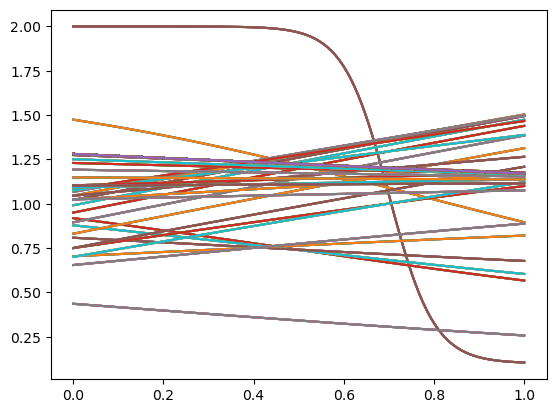

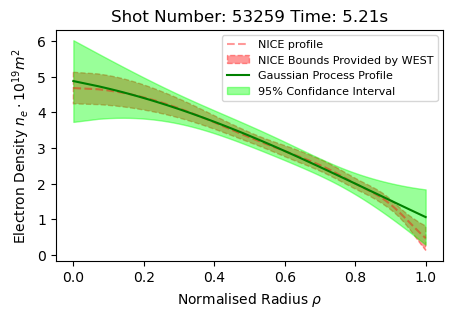

In [40]:
def chol_inv(A):
    L = np.linalg.cholesky(A)
    return np.linalg.inv(L).T @ np.linalg.inv(L)
def chol_det(A):
    L = np.linalg.cholesky(A)
    return np.prod(np.diag(L))

def KRcov_li(params,trial_EXP_ER):
    #covergence matrix of Prior
    K = Kernel(rho_1d, params)
    #add a small term onto diagonal of matricies to be inverted.
    #this ensures it is positive definate and cholensky matrix can be computed
    K[np.diag_indices_from(K)] += 1e-8 
    #covergence matrix of Likelyhood
    cov_li = np.diag(np.repeat(trial_EXP_ER,M)) # M is number of channels
    R = compute_response_matrix(geo, equi, dens_prof.rho_tor_norm_1d)
    return K, R, cov_li

def MargLi(params):
    K, R, cov_li = KRcov_li(params,EXP_ER)
    invertable = cov_li + R @ K @ R.T
    #add a small term onto diagonal of matricies to be inverted.
    #this ensures it is positive definate and cholensky matrix can be computed
    invertable[np.diag_indices_from(invertable)] += 1e-8
    if np.isinf(invertable).any() or np.isnan(invertable).any():
        print('matrix has an inf or nan with causes issues for square root, reurning inf for marginal likelihood')
        return float('inf')
    elif np.any(np.linalg.eigvals(invertable) <= 0):
        print('Matrix is not positive definate, returning inf for marginal likelyhood')
        return float('inf')
    return 0.5*np.log(chol_det(invertable)) + 0.5*(lid_d.T@chol_inv(invertable)@lid_d)                
  

results = minimize(MargLi, x0=initial_params)
# results = basinhopping(MargLi, x0=initial_params, niter=2)
print(results)
best_params = results.x
# best_params = initial_params
# MargLi(x0)

def PlotBest(params,trial_EXP_ER): 
    K, R, cov_li = KRcov_li(params,trial_EXP_ER)
    cov_post3 = chol_inv(R.T @ chol_inv(cov_li) @ R + chol_inv(K))
    mu_post3 = mu_prior + cov_post3 @ R.T @ chol_inv(cov_li) @ (lid_d - R @ mu_prior)
    error_bars3 = 1.96*np.sqrt(np.diagonal(cov_post3))

    print('\n\nNot good if zero, as need to be chol_inverted.')
    print('The Determinent of K is:', chol_det(K))
    print('The Determinent of cov_li is:', chol_det(cov_li))
    print('The Determinent of cov_post3 is:', chol_det(cov_post3))

    figGPR3 = plt.figure(figsize=(5,3))
    plt.title('Shot Number: '+str(shot)+' Time: '+str(t)+'s')
    plt.xlabel(r'Normalised Radius $\rho$')
    plt.ylabel(r'Electron Density $n_e \cdot 10^{19} m^2$')
    plt.plot(rho_1d, dens_prof.dens_1d,color=(1,0,0,0.4), linestyle='--', label='NICE profile')
    plt.fill_between(rho_1d, dens_prof.dens_1d_lower, dens_prof.dens_1d_upper, color=(1,0,0,0.4),linestyle='--',label='NICE Bounds Provided by WEST')
    plt.plot(rho_1d, mu_post3,'g', label='Gaussian Process Profile')
    plt.fill_between(rho_1d, mu_post3-error_bars3, mu_post3+error_bars3, color=(0,1,0,0.4),linestyle='-',label='95% Confidance Interval')
    plt.legend(fontsize = 8)
    plt.show()

PlotBest(best_params, EXP_ER)

In [ ]:
import optuna

def objective(trial):
    amp = trial.suggest_float('amp', 0, 10)
    l = trial.suggest_float('l', 0, 0.2)
    params = [amp,l]
    return MargLi(params)
    
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=500)

study.best_params

In [84]:
invertable = np.array([[-1,0,0],[0,3,0],[0,0,3]])
(np.linalg.eigvals(invertable) <= 0).any()

True

In [20]:
print(results)


      fun: -4.794833512153887
 hess_inv: array([[ 0.45942235, -0.20062507],
       [-0.20062507,  0.20675377]])
      jac: array([ 5.60283661e-06, -6.55651093e-07])
  message: 'Optimization terminated successfully.'
     nfev: 93
      nit: 22
     njev: 31
   status: 0
  success: True
        x: array([5.2267992 , 1.13968046])


# Dynamic Kernel


In [17]:
np.sqrt(-1)

/tmp/ipykernel_4108/3438155168.py:1: RuntimeWarning: invalid value encountered in sqrt
  np.sqrt(-1)


nan

In [25]:
def NonStatLengthScaleKernel(rho_1d,params):
    RHOA, RHOB = np.meshgrid(rho_1d,rho_1d)
    #amplitude determins how far the model can go from the mean
#     amp = params[0]
#     #length scale determines smoothness, how correlated the function should be at a distance
    l = np.array(params[1:])
    LA, LB = np.meshgrid(l,l)
#     mag = (RHOA - RHOB) * (RHOA - RHOB)
    scale1 = 2 * LA * LB
    scale2 = LA * LA + LB * LB
    print(scale1)
    print(scale2)
    print((scale1/scale2)**(1/2))
#     return amp * np.sqrt(scale1/scale2) * np.exp(-(mag/scale2))

K = NonStatLengthScaleKernel(rho_1d,x0)

[[3.7538 3.7538 3.7538 ... 3.7538 3.7538 3.7538]
 [3.7538 3.7538 3.7538 ... 3.7538 3.7538 3.7538]
 [3.7538 3.7538 3.7538 ... 3.7538 3.7538 3.7538]
 ...
 [3.7538 3.7538 3.7538 ... 3.7538 3.7538 3.7538]
 [3.7538 3.7538 3.7538 ... 3.7538 3.7538 3.7538]
 [3.7538 3.7538 3.7538 ... 3.7538 3.7538 3.7538]]
[[3.7538 3.7538 3.7538 ... 3.7538 3.7538 3.7538]
 [3.7538 3.7538 3.7538 ... 3.7538 3.7538 3.7538]
 [3.7538 3.7538 3.7538 ... 3.7538 3.7538 3.7538]
 ...
 [3.7538 3.7538 3.7538 ... 3.7538 3.7538 3.7538]
 [3.7538 3.7538 3.7538 ... 3.7538 3.7538 3.7538]
 [3.7538 3.7538 3.7538 ... 3.7538 3.7538 3.7538]]
[[1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 ...
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]]
